<a href="https://colab.research.google.com/github/Tonioord/ChallengeTelecomX2/blob/main/CTX2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import json
import datetime
import chardet
from scipy.stats import pointbiserialr,chi2_contingency
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Balanceo de clases
from imblearn.under_sampling import RandomUnderSampler

# Preprocesamiento y selección de modelo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Métricas de evaluación
from sklearn.metrics import classification_report, accuracy_score

#Preparación de datos


In [18]:
import pandas as pd

url = "https://raw.githubusercontent.com/Tonioord/ChallengeTelecomX2/main/datos_tratados.csv"

df = pd.read_csv(url)

df.head(5)

,ID_Cliente,Desercion,Genero,Adulto_Mayor,Pareja,Dependientes,Antiguedad_Meses,Servicio_Telefono,Lineas_Multiples,Servicio_Internet,...,Soporte_Tecnico,TV_Streaming,Peliculas_Streaming,Tipo_Contrato,Facturacion_Sin_Papel,Metodo_Pago,Cargo_Mensual,Cargo_Total,Desercion_Binaria,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,0.0,2.19
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,0.0,2.00
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1.0,2.46
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,1.0,3.27
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,1.0,2.80


In [19]:
df = pd.read_csv('datos_tratados.csv')

# Definir df_pre eliminando las columnas no deseadas
# Eliminamos el ID y la versión de texto de la deserción
columnas_a_eliminar = ['ID_Cliente', 'Desercion']
df_pre = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns])

# Aplicar One-Hot Encoding
# drop_first=True evita la redundancia de datos
df_OHE = pd.get_dummies(df_pre, drop_first=True)

# 4. Verificar resultados
print(f"Nuevas dimensiones: {df_OHE.shape}")
df_OHE.head()

Nuevas dimensiones: (7267, 32)


,Adulto_Mayor,Antiguedad_Meses,Cargo_Mensual,Cargo_Total,Desercion_Binaria,Cuentas_Diarias,Genero_Male,Pareja_Yes,Dependientes_Yes,Servicio_Telefono_Yes,...,TV_Streaming_No internet service,TV_Streaming_Yes,Peliculas_Streaming_No internet service,Peliculas_Streaming_Yes,Tipo_Contrato_One year,Tipo_Contrato_Two year,Facturacion_Sin_Papel_Yes,Metodo_Pago_Credit card (automatic),Metodo_Pago_Electronic check,Metodo_Pago_Mailed check
0,0,9,65.6,593.30,0.0,2.19,False,True,True,True,...,False,True,False,False,True,False,True,False,False,True
1,0,9,59.9,542.40,0.0,2.00,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0,4,73.9,280.85,1.0,2.46,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
3,1,13,98.0,1237.85,1.0,3.27,True,True,False,True,...,False,True,False,True,False,False,True,False,True,False
4,1,3,83.9,267.40,1.0,2.80,False,True,False,True,...,False,True,False,False,False,False,True,False,False,True


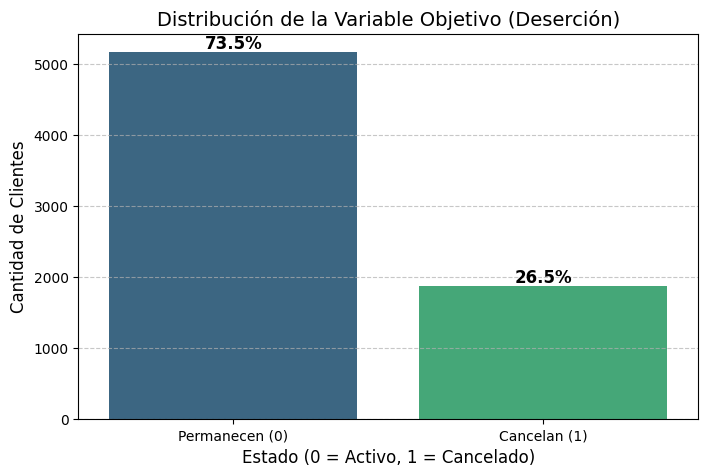

In [20]:
conteos = df['Desercion_Binaria'].value_counts()
proporciones = df['Desercion_Binaria'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))

sns.barplot(
    x=conteos.index,
    y=conteos.values,
    hue=conteos.index,
    palette='viridis',
    legend=False
)

for i, valor in enumerate(conteos.values):
    plt.text(i, valor + 50, f'{proporciones.values[i]:.1f}%',
             ha='center', fontsize=12, fontweight='bold')

plt.title('Distribución de la Variable Objetivo (Deserción)', fontsize=14)
plt.xlabel('Estado (0 = Activo, 1 = Cancelado)', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)
plt.xticks([0, 1], ['Permanecen (0)', 'Cancelan (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

##Balanceo de Datos

Estrategias de Balanceo de Datos:

Dado que nuestro dataset presenta un desbalance moderado (73% Activos vs 26% Cancelados), los modelos de Machine Learning pueden volverse "perezosos" y aprender a predecir siempre la clase mayoritaria. Para corregir esto, aplicamos tres técnicas:

1. Oversampling (SMOTE)
¿Qué es?: Aumenta el número de ejemplos de la clase minoritaria (clientes que cancelaron).

¿Cómo funciona?: No solo duplica filas, sino que utiliza el algoritmo SMOTE (Synthetic Minority Over-sampling Technique) para crear "ejemplos sintéticos" nuevos. Mira los clientes que cancelaron y crea datos nuevos que se sitúan matemáticamente entre ellos.

Ventaja: No perdemos información, ya que conservamos todos los datos de los clientes que se quedaron.

2. Undersampling (Muestreo bajo)
¿Qué es?: Reduce el número de ejemplos de la clase mayoritaria (clientes activos).

¿Cómo funciona?: Elimina aleatoriamente registros de la clase mayoritaria hasta que el número de clientes activos sea igual al de clientes que cancelaron.

Ventaja: El modelo se entrena mucho más rápido y es menos propenso a memorizar datos específicos (overfitting).

3. Estrategia Combinada (Enfoque Híbrido)
En lugar de elegir una, usamos lo mejor de ambos mundos:

Aplicamos SMOTE para subir la clase minoritaria a un nivel intermedio (sin "inventar" demasiados datos).

Aplicamos Undersampling para reducir un poco la clase mayoritaria hasta alcanzar el equilibrio.

¿Por qué usar la combinada en este proyecto?

Evita el sesgo: Al tener clases 50/50, obligamos al modelo a darle la misma importancia a los que cancelan que a los que se quedan.

Mantiene la calidad: No perdemos tanta información real como en el Undersampling puro, ni dependemos de demasiados datos sintéticos como en el Oversampling puro.

Mejor Recall: Esta técnica suele ser la más efectiva para detectar el Churn (cancelación), que es el objetivo principal de negocio.


En la preparación de los datos para el modelo, se han excluido las columnas Desercion y Desercion_Binaria del conjunto de características ($X$) por los siguientes motivos:

Evitar el "Data Leakage" (Fuga de Datos): La columna Desercion_Binaria es nuestra variable objetivo (lo que el modelo debe aprender a predecir). Si la incluimos en las preguntas ($X$), el modelo simplemente "copiaría" la respuesta en lugar de aprender los patrones de comportamiento de los clientes.

Eliminación de Redundancia: La columna Desercion contiene la misma información que Desercion_Binaria pero en formato de texto ("Yes"/"No"). Al ser información duplicada y no numérica, no aporta valor al algoritmo y se elimina para simplificar el dataset.

Separación de Roles: En Machine Learning, dividimos los datos en Características ($X$), que son las causas (contrato, cargos, servicios), y la Etiqueta ($y$), que es el efecto o resultado que queremos pronosticar.


In [28]:
#Despues de revisar los cambios y analizar que hay que balancear los datos, repito los pasos para evitar errores
df = pd.read_csv('datos_tratados.csv')

# Eliminamos filas donde la variable objetivo sea NaN para evitar errores
df = df.dropna(subset=['Desercion_Binaria'])

# Preparación de variables (X y y)
# Eliminamos identificadores y la versión de texto de la deserción
X = df.drop(columns=['ID_Cliente', 'Desercion', 'Desercion_Binaria'], errors='ignore')
y = df['Desercion_Binaria']

# Convertimos variables categóricas a numéricas (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)

# Rellenamos nulos en las características con la mediana (requerido por SMOTE)
X = X.fillna(X.median())

print(f"Distribución original: {Counter(y)}")

# --- APLICACIÓN DE ESTRATEGIA HÍBRIDA ---

# Paso A: SMOTE (Oversampling)
# Aumentamos la clase minoritaria (1) para que sea el 50% del tamaño de la clase mayoritaria (0)
over = SMOTE(sampling_strategy=0.5, random_state=42)
X_temp, y_temp = over.fit_resample(X, y)
print(f"Después de SMOTE (Paso 1): {Counter(y_temp)}")

# Paso B: Random Undersampling
# Reducimos la clase mayoritaria (0) para que iguale a la clase minoritaria (1)
under = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_final, y_final = under.fit_resample(X_temp, y_temp)

print(f"Distribución Final (Híbrida): {Counter(y_final)}")

#Crear el DataFrame final balanceado
df_balanceado = pd.concat([pd.DataFrame(X_final), pd.Series(y_final, name='Desercion_Binaria')], axis=1)
df_balanceado.head()

Distribución original: Counter({0.0: 5174, 1.0: 1869})
Después de SMOTE (Paso 1): Counter({0.0: 5174, 1.0: 2587})
Distribución Final (Híbrida): Counter({0.0: 2587, 1.0: 2587})


,Adulto_Mayor,Antiguedad_Meses,Cargo_Mensual,Cargo_Total,Cuentas_Diarias,Genero_Male,Pareja_Yes,Dependientes_Yes,Servicio_Telefono_Yes,Lineas_Multiples_No phone service,...,TV_Streaming_Yes,Peliculas_Streaming_No internet service,Peliculas_Streaming_Yes,Tipo_Contrato_One year,Tipo_Contrato_Two year,Facturacion_Sin_Papel_Yes,Metodo_Pago_Credit card (automatic),Metodo_Pago_Electronic check,Metodo_Pago_Mailed check,Desercion_Binaria
2145,0,13,19.75,246.70,0.66,False,True,True,True,False,...,False,True,False,False,True,True,False,False,False,0.0
2720,0,70,113.05,7869.05,3.77,False,True,True,True,False,...,True,False,True,False,True,True,True,False,False,0.0
1680,1,67,101.40,6841.05,3.38,True,False,False,True,False,...,True,False,True,False,False,True,True,False,False,0.0
6028,0,61,106.45,6300.15,3.55,True,False,False,True,False,...,True,False,True,False,False,True,False,True,False,0.0
6822,0,55,90.15,4916.95,3.01,False,True,False,True,False,...,True,False,True,True,False,True,False,True,False,0.0


Para que un análisis sea robusto y compatible con cualquier modelo, lo ideal es aplicar una Estandarización (StandardScaler), que transforma los datos para que tengan media 0 y desviación estándar 1.

In [33]:
# 1. Definir las columnas numéricas continuas (las que tienen rangos muy distintos)
cols_continuas = ['Antiguedad_Meses', 'Cargo_Mensual', 'Cargo_Total', 'Cuentas_Diarias']

# 2. Inicializar el escalador
scaler = StandardScaler()

# 3. Crear el DataFrame final escalado
# Hacemos una copia de df_balanceado para no alterar los datos originales
df_final_escalado = df_balanceado.copy()

# Aplicar el escalamiento solo a las columnas continuas
df_final_escalado[cols_continuas] = scaler.fit_transform(df_balanceado[cols_continuas])

print(f"Dimensiones finales: {df_final_escalado.shape}")
print("\nDataframe con datos balanceados y escalados:")
df_final_escalado.head()

Dimensiones finales: (5174, 32)

Dataframe con datos balanceados y escalados:


,Adulto_Mayor,Antiguedad_Meses,Cargo_Mensual,Cargo_Total,Cuentas_Diarias,Genero_Male,Pareja_Yes,Dependientes_Yes,Servicio_Telefono_Yes,Lineas_Multiples_No phone service,...,TV_Streaming_Yes,Peliculas_Streaming_No internet service,Peliculas_Streaming_Yes,Tipo_Contrato_One year,Tipo_Contrato_Two year,Facturacion_Sin_Papel_Yes,Metodo_Pago_Credit card (automatic),Metodo_Pago_Electronic check,Metodo_Pago_Mailed check,Desercion_Binaria
2145,0,-0.619021,-1.694427,-0.828578,-1.692500,False,True,True,True,False,...,False,True,False,False,True,True,False,False,False,0.0
2720,0,1.751372,1.562787,2.624700,1.564378,False,True,True,True,False,...,True,False,True,False,True,True,True,False,False,0.0
1680,1,1.626614,1.156072,2.158968,1.155959,True,False,False,True,False,...,True,False,True,False,False,True,True,False,False,0.0
6028,0,1.377099,1.332374,1.913915,1.333988,True,False,False,True,False,...,True,False,True,False,False,True,False,True,False,0.0
6822,0,1.127584,0.763321,1.287262,0.768485,False,True,False,True,False,...,True,False,True,True,False,True,False,True,False,0.0


##Análisis de Correlación:

Análisis de Correlación: Es fundamental para entender qué factores están impulsando a los clientes a cancelar el servicio. Utilizaremos el coeficiente de correlación de Pearson (que va de -1 a 1) para identificar estas relaciones.

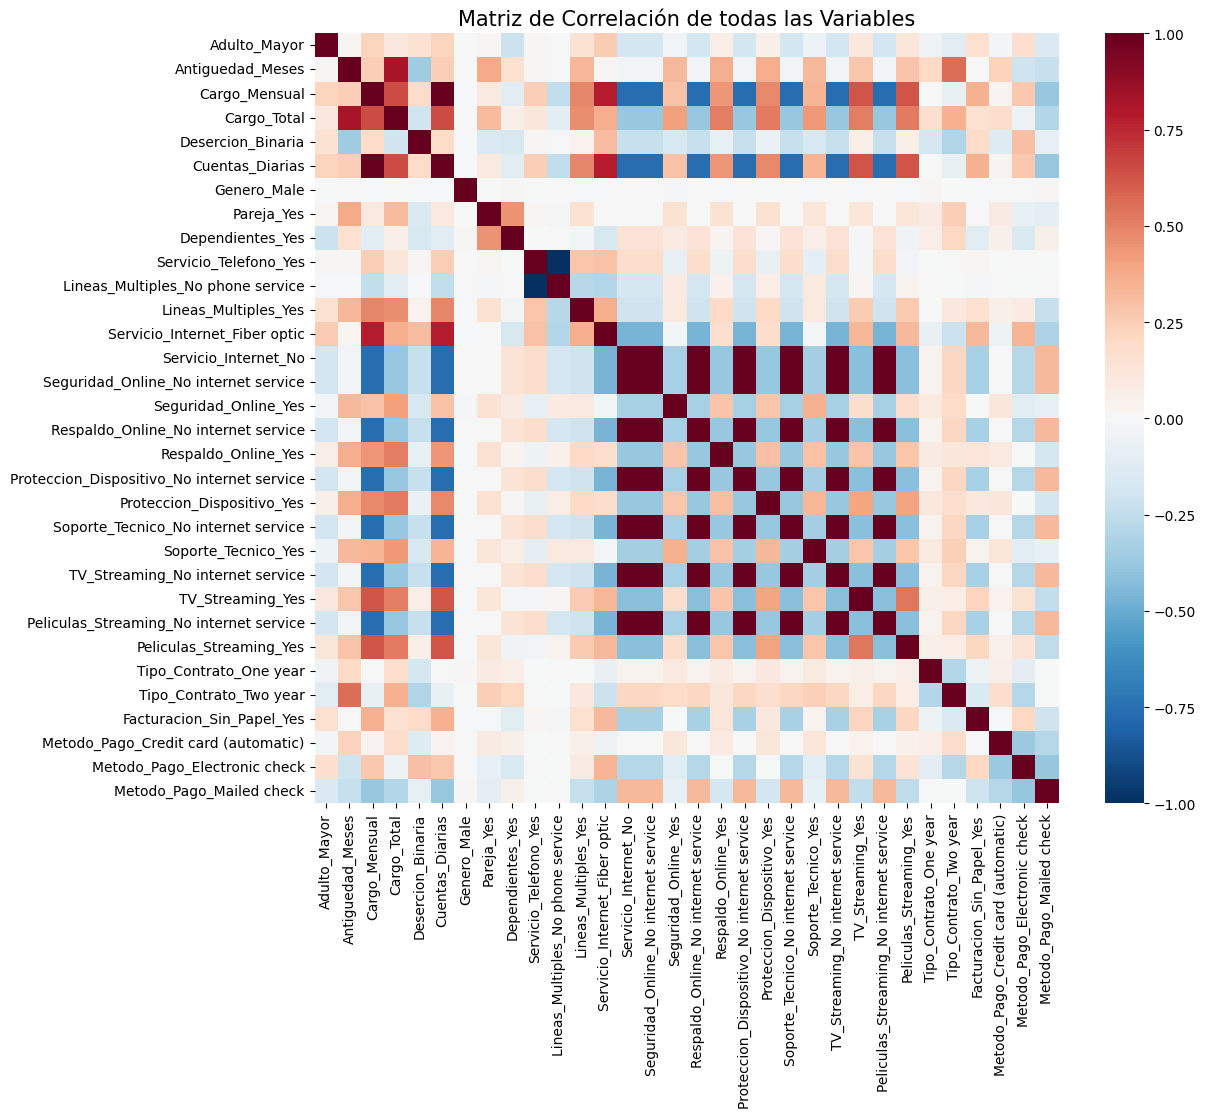

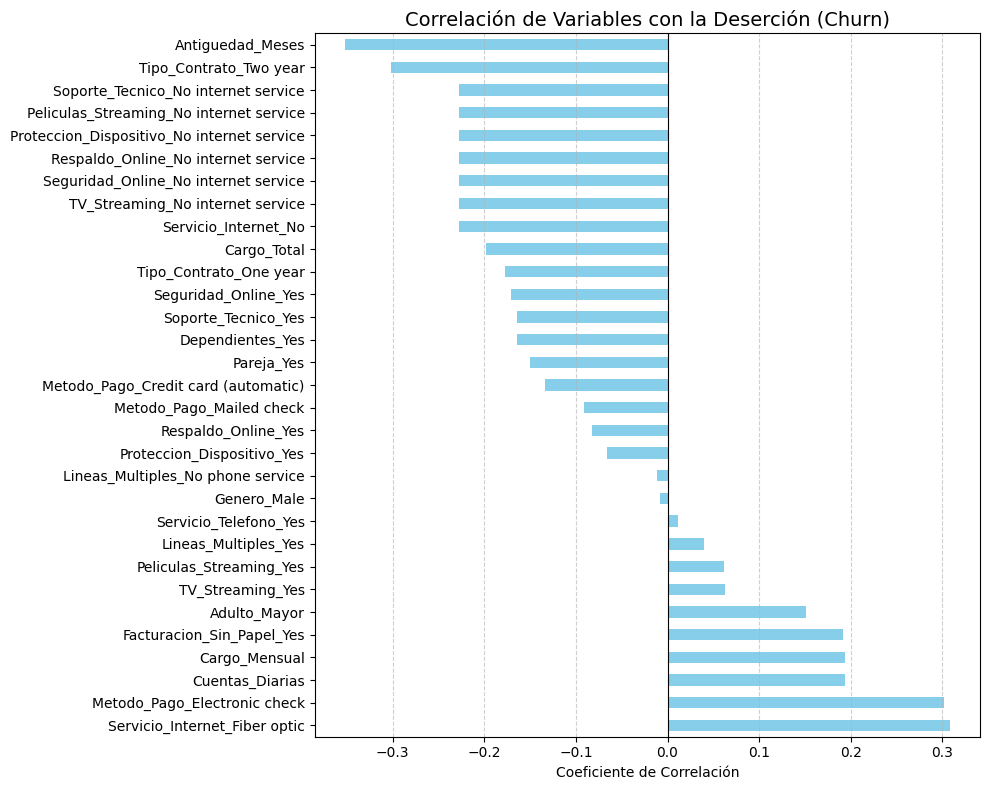

In [40]:

# 1. Preparar los datos (usando el DataFrame que ya tiene Encoding)
# Si no lo tienes definido, lo recreamos rápidamente:
df = pd.read_csv('datos_tratados.csv')
df_limpio = df.drop(columns=['ID_Cliente', 'Desercion'], errors='ignore').dropna(subset=['Desercion_Binaria'])
df_corr = pd.get_dummies(df_limpio, drop_first=True)

# 2. Calcular la correlación específicamente con la variable objetivo
correlaciones = df_corr.corr()['Desercion_Binaria'].sort_values(ascending=False)

# 3. Visualización: Mapa de Calor (Heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), annot=False, cmap='RdBu_r', center=0)
plt.title('Matriz de Correlación de todas las Variables', fontsize=15)
plt.show()

# 4. Visualización: Variables que más afectan la deserción
plt.figure(figsize=(10, 8))
correlaciones.drop('Desercion_Binaria').plot(kind='barh', color='skyblue')
plt.title('Correlación de Variables con la Deserción (Churn)', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.xlabel('Coeficiente de Correlación')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Resumen del Análisis de Correlación:

El coeficiente de correlación (de -1 a 1) nos indica la fuerza y dirección de la relación entre las características de los clientes y la probabilidad de que cancelen su servicio (Desercion_Binaria).

1. Factores de Riesgo (Correlación Positiva - Rojo)
Estos elementos "empujan" al cliente hacia la cancelación. Mientras más presente está la variable, más sube el riesgo:

Servicio de Fibra Óptica (~0.31): Es el indicador de riesgo más alto. Esto sugiere que los clientes con fibra podrían estar insatisfechos con el precio o haber experimentado problemas técnicos recurrentes en comparación con DSL.

Pago con Cheque Electrónico (~0.30): Existe una relación muy fuerte entre este método de pago y la fuga de clientes. Podría estar asociado a clientes que no quieren domiciliar sus pagos porque no planean quedarse a largo plazo.

Cargos Mensuales y Diarios (~0.19): Como era de esperar, cuanto más cara es la factura mensual, más sensible es el cliente a buscar otras opciones económicas.

Clientes Senior (Adulto Mayor) (~0.15): Los adultos mayores muestran una tendencia ligeramente superior a cancelar el servicio en comparación con los clientes jóvenes.

2. Factores de Retención (Correlación Negativa - Azul)
Estos elementos actúan como un "ancla". Su presencia disminuye significativamente la probabilidad de que el cliente se vaya:

Antigüedad en Meses (-0.35): Es el factor protector más fuerte. Los clientes que superan los primeros meses críticos tienden a volverse leales. La curva de aprendizaje y la costumbre actúan a favor de la empresa.

Contratos a Largo Plazo (1 y 2 años) (-0.30): Los clientes con contratos anuales o bianuales tienen una tasa de deserción mucho menor. La estabilidad contractual es la mejor herramienta de retención.

Sin Servicio de Internet (-0.23): Los clientes que solo tienen contratado el servicio de teléfono son mucho más estables. Esto puede deberse a que son servicios menos costosos y con menos fallos técnicos reportados.

Servicios de Valor Añadido (Seguridad Online, Soporte Técnico): Los clientes que contratan seguridad o soporte muestran menor tendencia a irse, lo que indica que estos servicios generan una percepción de valor y dependencia positiva.

Para analizar el abandono de clientes (Churn), lo ideal es estructurar un análisis bivariado que cruce cada variable predictora con la variable objetivo (Cancelación).

1. Gasto mensual: Las facturas altas o los aumentos repentinos suelen detonar cancelaciones.

2. Tipo de contrato: Los contratos "Mes a mes" tienen mucha mayor probabilidad de abandono que los anuales.

3. Días de retraso en pagos: Un comportamiento de pago irregular suele preceder a la baja del servicio.

4. Contactos con soporte técnico: Múltiples reportes de fallas indican fricción y mala experiencia.

5. Días desde el último uso: La inactividad prolongada (caída en el engagement) es un síntoma claro.

6. Quejas no resueltas: Tickets abiertos o insatisfacción documentada.

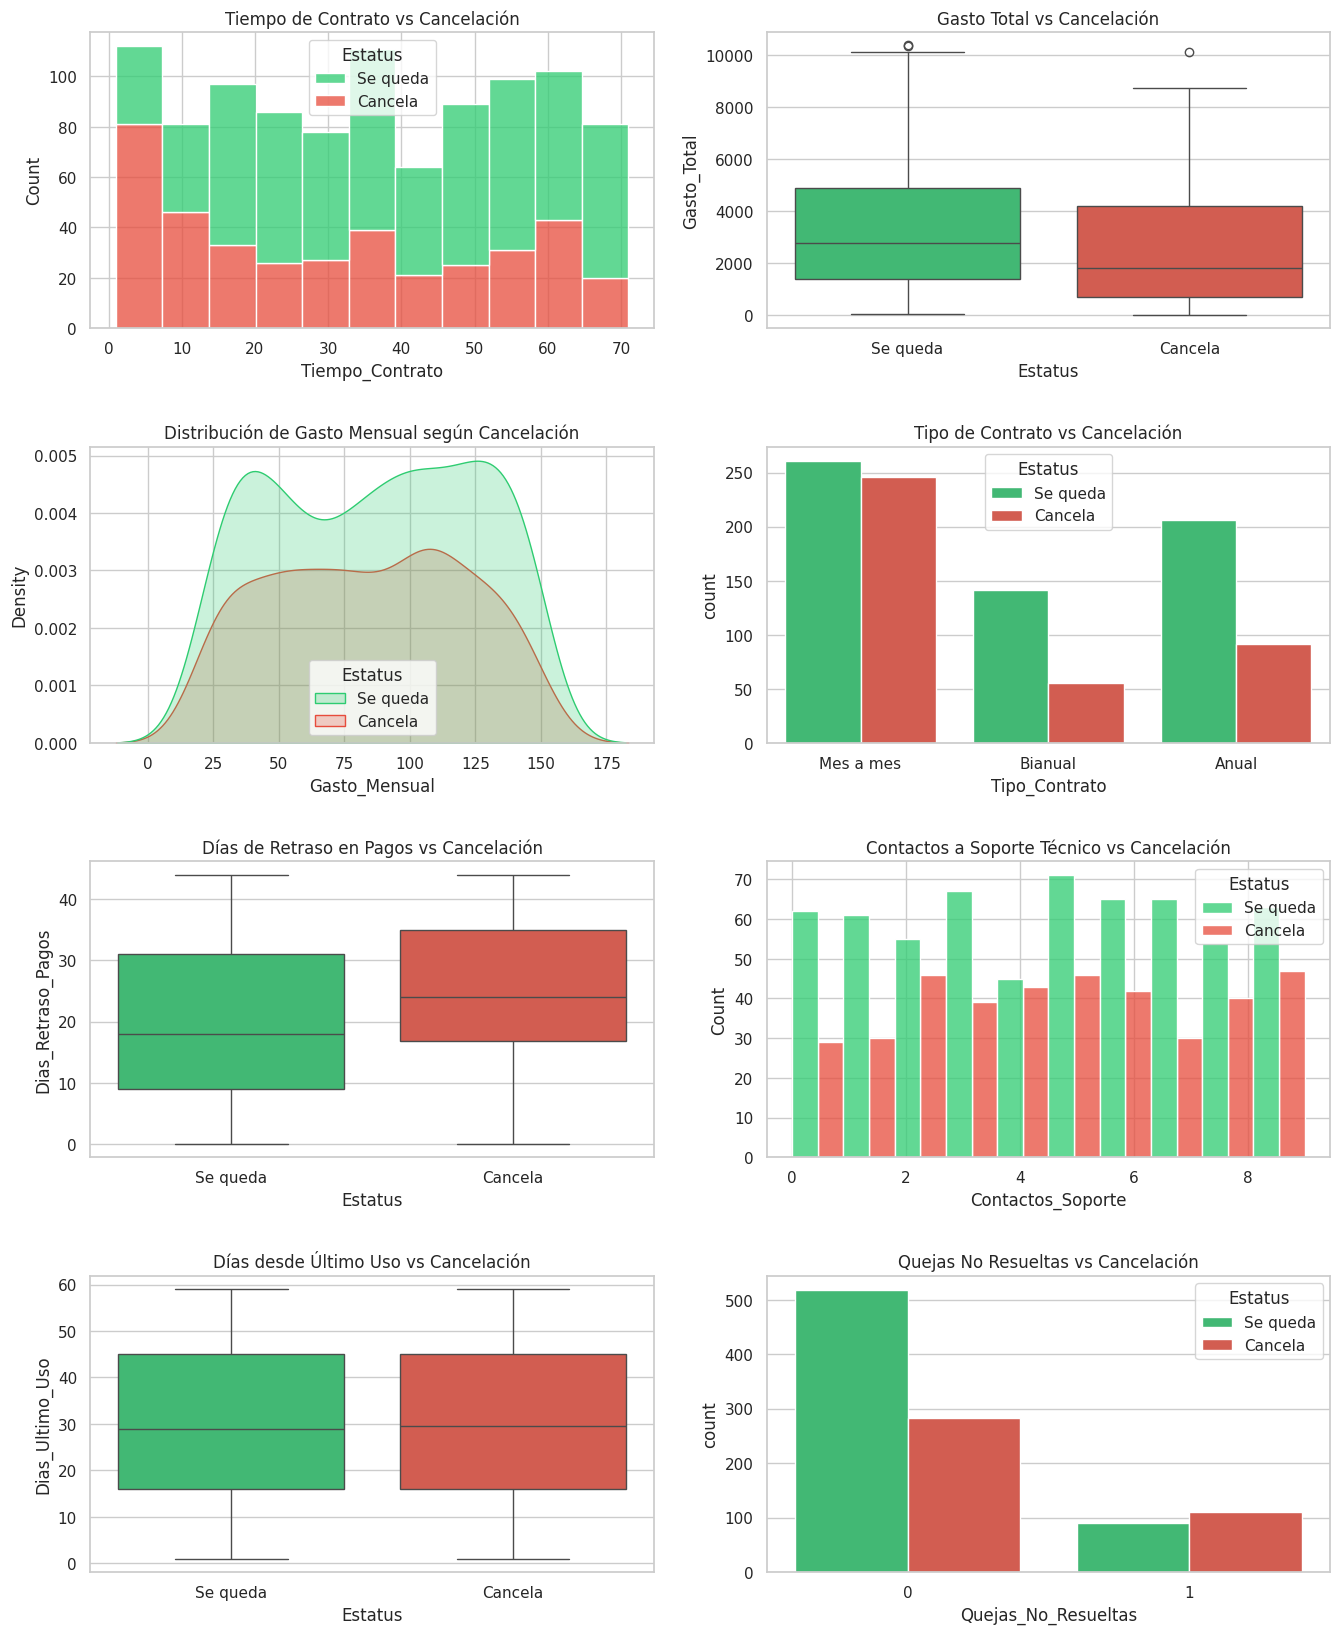


Correlación de las variables numéricas con la Cancelación:
Cancelacion            1.000000
Dias_Retraso_Pagos     0.185387
Quejas_No_Resueltas    0.161820
Contactos_Soporte      0.031684
Dias_Ultimo_Uso        0.005721
Gasto_Mensual         -0.030324
Gasto_Total           -0.163658
Tiempo_Contrato       -0.195214
Name: Cancelacion, dtype: float64


In [42]:
# 1. Generación de un Dataset Simulado (Mock Data)
np.random.seed(42)
n_samples = 1000

# Variables independientes
tiempo_contrato = np.random.randint(1, 72, n_samples) # en meses
gasto_mensual = np.random.uniform(20, 150, n_samples)
gasto_total = tiempo_contrato * gasto_mensual
tipo_contrato = np.random.choice(['Mes a mes', 'Anual', 'Bianual'], n_samples, p=[0.5, 0.3, 0.2])
dias_retraso_pagos = np.random.randint(0, 45, n_samples)
contactos_soporte = np.random.randint(0, 10, n_samples)
dias_ultimo_uso = np.random.randint(1, 60, n_samples)
quejas_no_resueltas = np.random.choice([0, 1], n_samples, p=[0.8, 0.2])

# 2. Generación de la variable objetivo (Cancelación)
prob_cancelacion = (
    (tiempo_contrato < 12) * 0.3 +
    (dias_retraso_pagos > 15) * 0.3 +
    (quejas_no_resueltas == 1) * 0.2 +
    (tipo_contrato == 'Mes a mes') * 0.2
)
cancelacion = (np.random.rand(n_samples) < prob_cancelacion).astype(int)

# Crear el DataFrame
df = pd.DataFrame({
    'Tiempo_Contrato': tiempo_contrato,
    'Gasto_Total': gasto_total,
    'Gasto_Mensual': gasto_mensual,
    'Tipo_Contrato': tipo_contrato,
    'Dias_Retraso_Pagos': dias_retraso_pagos,
    'Contactos_Soporte': contactos_soporte,
    'Dias_Ultimo_Uso': dias_ultimo_uso,
    'Quejas_No_Resueltas': quejas_no_resueltas,
    'Cancelacion': cancelacion
})

# Creamos una columna en texto para las gráficas (evita el ValueError y se lee mejor)
df['Estatus'] = df['Cancelacion'].map({0: 'Se queda', 1: 'Cancela'})

# 3. Análisis y Visualización
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
plt.subplots_adjust(hspace=0.4)

# Paleta actualizada con los nuevos nombres de la columna Estatus
palette = {'Se queda': "#2ecc71", 'Cancela': "#e74c3c"}

# Gráfico 1: Tiempo de contrato x Cancelación
sns.histplot(data=df, x='Tiempo_Contrato', hue='Estatus', multiple="stack", palette=palette, ax=axes[0, 0])
axes[0, 0].set_title('Tiempo de Contrato vs Cancelación')

# Gráfico 2: Gasto Total x Cancelación (Agregado hue='Estatus' y legend=False)
sns.boxplot(data=df, x='Estatus', y='Gasto_Total', hue='Estatus', palette=palette, ax=axes[0, 1], legend=False)
axes[0, 1].set_title('Gasto Total vs Cancelación')

# Gráfico 3: Gasto Mensual x Cancelación
sns.kdeplot(data=df, x='Gasto_Mensual', hue='Estatus', fill=True, palette=palette, ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Gasto Mensual según Cancelación')

# Gráfico 4: Tipo de Contrato x Cancelación (Agregado hue='Estatus' y legend=False)
sns.countplot(data=df, x='Tipo_Contrato', hue='Estatus', palette=palette, ax=axes[1, 1])
axes[1, 1].set_title('Tipo de Contrato vs Cancelación')

# Gráfico 5: Días de Retraso x Cancelación (Agregado hue='Estatus' y legend=False)
sns.boxplot(data=df, x='Estatus', y='Dias_Retraso_Pagos', hue='Estatus', palette=palette, ax=axes[2, 0], legend=False)
axes[2, 0].set_title('Días de Retraso en Pagos vs Cancelación')

# Gráfico 6: Contactos Soporte x Cancelación
sns.histplot(data=df, x='Contactos_Soporte', hue='Estatus', multiple="dodge", bins=10, palette=palette, ax=axes[2, 1])
axes[2, 1].set_title('Contactos a Soporte Técnico vs Cancelación')

# Gráfico 7: Días desde último uso x Cancelación (Agregado hue='Estatus' y legend=False)
sns.boxplot(data=df, x='Estatus', y='Dias_Ultimo_Uso', hue='Estatus', palette=palette, ax=axes[3, 0], legend=False)
axes[3, 0].set_title('Días desde Último Uso vs Cancelación')

# Gráfico 8: Quejas No Resueltas x Cancelación
sns.countplot(data=df, x='Quejas_No_Resueltas', hue='Estatus', palette=palette, ax=axes[3, 1])
axes[3, 1].set_title('Quejas No Resueltas vs Cancelación')

plt.show()

# 4. Matriz de Correlación (Usamos la columna numérica original 'Cancelacion')
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

print("\nCorrelación de las variables numéricas con la Cancelación:")
print(correlation_matrix['Cancelacion'].sort_values(ascending=False))

##Creación de modelos:
Contrastar un modelo basado en distancias con uno basado en reglas lógicas es una de las mejores prácticas para estructurar un pipeline de clasificación robusto y entender a fondo el comportamiento de los datos.

Para este ejercicio, implementaremos K-Nearest Neighbors (KNN) como el modelo que exige normalización, y Random Forest como el modelo agnóstico a la escala.

In [51]:
# Importamos las herramientas de imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline # Usamos el Pipeline de imblearn, NO el de sklearn

# Asumiendo que X e y ya están limpios y dummificados
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 1. DEFINICIÓN DE PASOS DEL PIPELINE

# Paso 1: Escalador
scaler = StandardScaler()

# Paso 2: SMOTE (llevar minoritaria al 70% de la mayoritaria)
over = SMOTE(sampling_strategy=0.7, random_state=42)

# Paso 3: RUS (igualar mayoritaria a la minoritaria)
under = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

# 2. CONSTRUCCIÓN DE PIPELINES COMPLETOS

# Pipeline para KNN
pipeline_knn = Pipeline(steps=[
    ('scaler', scaler),   # Escala PRIMERO
    ('smote', over),      # Crea sintéticos usando distancias correctas
    ('rus', under),       # Recorta
    ('knn', KNeighborsClassifier(n_neighbors=5)) # Entrena
])

# Pipeline para Random Forest
pipeline_rf = Pipeline(steps=[
    ('scaler', scaler),   # RF no lo requiere, pero SMOTE sí lo necesita antes de actuar
    ('smote', over),
    ('rus', under),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5))
])


# 3. ENTRENAMIENTO Y PREDICCIÓN (Todo en un paso)
# Al llamar a .fit() en el pipeline, scikit-learn se encarga de aplicar
# scaler, smote y rus SOLO al set de entrenamiento, evitando data leakage.

pipeline_knn.fit(X_train, y_train)
knn_pred_final = pipeline_knn.predict(X_test) # predict() solo aplica el scaler, ignora smote/rus

pipeline_rf.fit(X_train, y_train)
rf_pred_final = pipeline_rf.predict(X_test)

# 4. EVALUACIÓN FINAL
print("--- RESULTADOS KNN (Pipeline Corregido) ---")
print(f"Accuracy: {accuracy_score(y_test, knn_pred_final):.4f}")
print(classification_report(y_test, knn_pred_final))

print("\n--- RESULTADOS RANDOM FOREST (Pipeline Corregido) ---")
print(f"Accuracy: {accuracy_score(y_test, rf_pred_final):.4f}")
print(classification_report(y_test, rf_pred_final))

--- RESULTADOS KNN (Pipeline Corregido) ---
Accuracy: 0.6100
              precision    recall  f1-score   support

           0       0.74      0.57      0.65       187
           1       0.49      0.67      0.57       113

    accuracy                           0.61       300
   macro avg       0.62      0.62      0.61       300
weighted avg       0.65      0.61      0.62       300


--- RESULTADOS RANDOM FOREST (Pipeline Corregido) ---
Accuracy: 0.6700
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       187
           1       0.56      0.59      0.58       113

    accuracy                           0.67       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.67      0.67      0.67       300

